In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import pathlib
import matplotlib.pyplot as plt
from pandas.core.common import flatten
from random import sample
from compounding import saving_summary, compound

In [2]:
def read_jsonfile(path: pathlib.Path):
    with open(path, "r") as file:
        obj = json.load(file)
    return obj

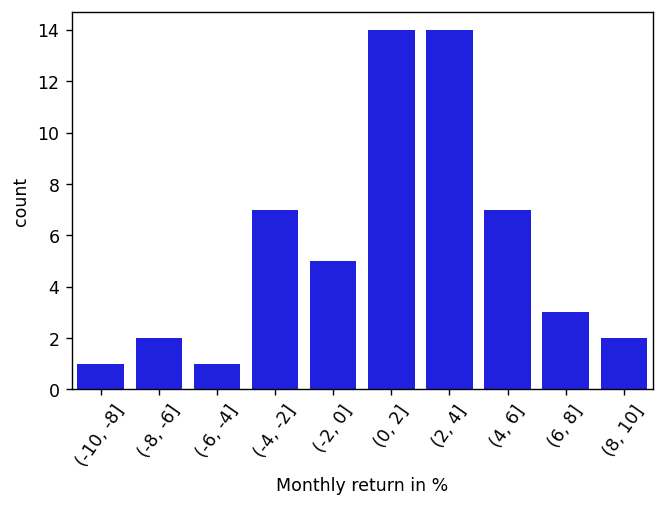

In [15]:
path = pathlib.Path(f'../data/monthly-returns.json')
returns = read_jsonfile(path)
return_binned_pct = pd.cut(
    np.array(returns['values']) * 100, 
    bins = [ -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10 ]
)
fig, ax = plt.subplots(dpi = 125)
sns.countplot(x = return_binned_pct, ax = ax, color = "blue")
plt.xticks(rotation=55);
plt.xlabel('Monthly return in %');

In [3]:
periods = 120
saving_rate = 5_000
path = pathlib.Path(f'../data/realized-paths-{periods}.json')
realized_paths = read_jsonfile(path)

In [4]:
sampled_returns = list(map(compound, realized_paths.values()))
mean_returns = np.mean(sampled_returns)
percentiles = [np.quantile(sampled_returns, q) for q in np.arange(0, 1.001, 0.01)]

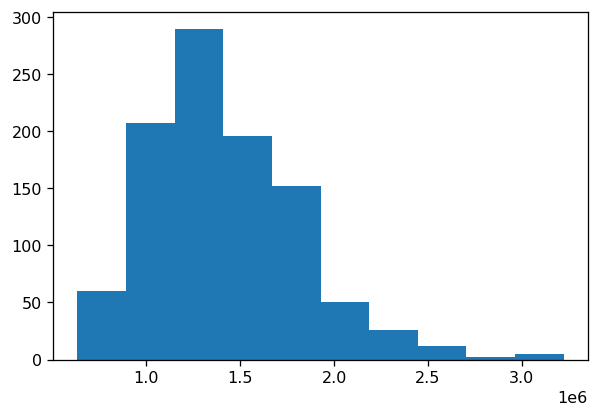

In [5]:
fig, ax = plt.subplots(dpi = 115)
ax.hist(sampled_returns);

In [6]:
i=60
saving = saving_summary(
    interest_rates=realized_paths[str(i)], 
    saving=saving_rate,
)
pd.DataFrame(saving).set_index('time').divide(1_000_000).round(2)

,total
time,
0,0.00
1,0.01
2,0.01
3,0.02
4,0.02
...,...
116,1.73
117,1.67
118,1.75


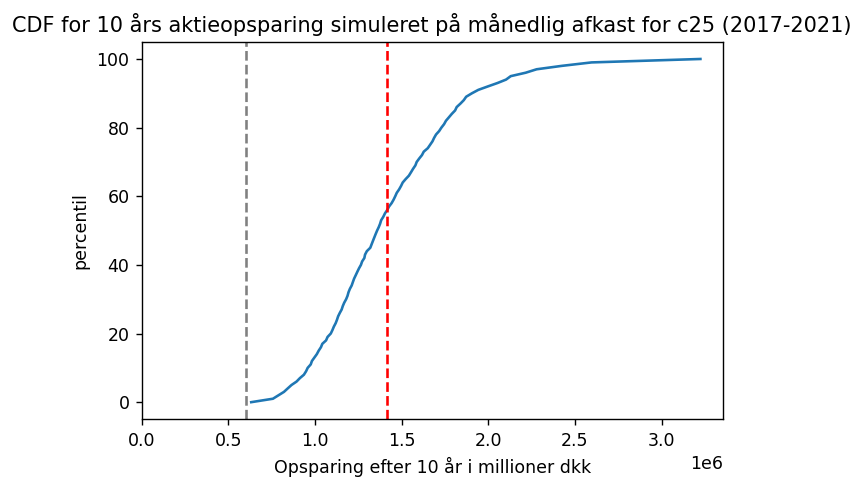

In [7]:
fig, ax = plt.subplots(dpi = 125)
ax.plot(percentiles, range(len(percentiles)))
ax.set(ylabel = "percentil")
ax.set(xlabel = f"Opsparing efter {periods // 12} år i millioner dkk")
ax.set(title  = f"CDF for {periods // 12} års aktieopsparing simuleret på månedlig afkast for c25 (2017-2021)")
ax.axvline(mean_returns, linestyle = "--", color = "red")
ax.axvline(periods * saving_rate, linestyle = "--", color = "grey")
ax.set_xlim(0)
plt.show()